In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install albumentations==0.4.3

     |████████████████████████████████| 3.2MB 2.8MB/s 
     |████████████████████████████████| 634kB 37.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.3-cp36-none-any.whl size=60764 sha256=31fe865bf87f3cb78a4185bcffd5a0a6b5f0c48414819b5f77bccd397ea79c60
  Stored in directory: /root/.cache/pip/wheels/20/16/8e/d3bec34bf30adff30929226f0b83cc8c005b5af131f51db9d0
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=61333f72cb238acd101c197db7c8b47a77ca8680d61db4e2e71a1784ff02bdf5
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
from __future__ import print_function, division, absolute_import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn.functional as F
import os
import cv2

# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm
import math
import torch.utils.model_zoo as model_zoo

from PIL import Image, ImageOps, ImageEnhance
from albumentations.core.transforms_interface import ImageOnlyTransform

from albumentations import (
    PadIfNeeded,
    GaussianBlur,
    Flip,
    HorizontalFlip,
    Transpose,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    Rotate,
    RandomBrightnessContrast,    
    RandomGamma,
    ShiftScaleRotate ,
    GaussNoise,
    Blur,
    MotionBlur,Cutout
)
my_size = 128

In [0]:
train_aug = Compose([ 
    ShiftScaleRotate(rotate_limit=10, scale_limit=.1),Cutout(num_holes=1, max_h_size=32, max_w_size=32, fill_value=0, always_apply=False, p=0.7),
    OneOf([
        GridDistortion(distort_limit =0.05 ,border_mode=cv2.BORDER_CONSTANT,value =1, p=0.1),
        OpticalDistortion(p=0.1, distort_limit= 0.05, shift_limit=0.2,border_mode=cv2.BORDER_CONSTANT,value =1)                  
        ], p=0.3),
    OneOf([
        Blur(),
        GaussianBlur(blur_limit=1)
        ], p=0.3),    
    RandomGamma(p=0.3)])

In [0]:
class ToTensor:
    def __call__(self, data):
        if isinstance(data, tuple):
            return tuple([self._to_tensor(image) for image in data])
        else:
            return self._to_tensor(data)

    def _to_tensor(self, data):
        if len(data.shape) == 3:
            return torch.from_numpy(data.transpose(2, 0, 1).astype(np.float32))
        else:
            return torch.from_numpy(data[None, :, :].astype(np.float32))


class Normalize:
    def __init__(self, mean, std):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, image):
        image = np.asarray(image).astype(np.float32) / 255.
        image = (image - self.mean) / self.std
        return image

In [0]:
class Selayer(nn.Module):

    def __init__(self, inplanes):
        super(Selayer, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(inplanes, int(inplanes / 16), kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(int(inplanes / 16), inplanes, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        out = self.global_avgpool(x)

        out = self.conv1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.sigmoid(out)

        return x * out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, cardinality, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)

        self.conv2 = nn.Conv2d(planes * 2, planes * 2, kernel_size=3, stride=stride,
                               padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 2)

        self.conv3 = nn.Conv2d(planes * 2, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)

        self.selayer = Selayer(planes * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.selayer(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SeResNeXt(nn.Module):

    def __init__(self, block, layers, cardinality=32, num_classes=1000):
        super(SeResNeXt, self).__init__()
        self.cardinality = cardinality
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, self.cardinality, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, self.cardinality))
                             
        # vowel_diacritic
        self.fc1 = nn.Linear(2048,11)
        # grapheme_root
        self.fc2 = nn.Linear(2048,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(2048,7)
        return nn.Sequential(*layers)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        
        return x1,x2,x3


def se_resnext50(**kwargs):
    """Constructs a SeResNeXt-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SeResNeXt(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def se_resnext101(**kwargs):
    """Constructs a SeResNeXt-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SeResNeXt(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def se_resnext152(**kwargs):
    """Constructs a SeResNeXt-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SeResNeXt(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

In [7]:
train = pd.read_csv('/content/drive/My Drive/bengaliaicv19feather/train.csv')
data0 = pd.read_feather('/content/drive/My Drive/black_128/train_data_0_ors.feather')
data1 = pd.read_feather('/content/drive/My Drive/black_128/train_data_1_ors.feather')
data2 = pd.read_feather('/content/drive/My Drive/black_128/train_data_2_ors.feather')  
data3 = pd.read_feather('/content/drive/My Drive/black_128/train_data_3_ors.feather')

'''data0 = pd.read_feather('/content/drive/My Drive/black64/train_data_0_64.feather')
data1 = pd.read_feather('/content/drive/My Drive/black64/train_data_1_64.feather')
data2 = pd.read_feather('/content/drive/My Drive/black64/train_data_2_64.feather')  
data3 = pd.read_feather('/content/drive/My Drive/black64/train_data_3_64.feather')'''

"data0 = pd.read_feather('/content/drive/My Drive/black64/train_data_0_64.feather')\ndata1 = pd.read_feather('/content/drive/My Drive/black64/train_data_1_64.feather')\ndata2 = pd.read_feather('/content/drive/My Drive/black64/train_data_2_64.feather')  \ndata3 = pd.read_feather('/content/drive/My Drive/black64/train_data_3_64.feather')"

In [0]:
data_full = pd.concat([data0,data1,data2,data3],ignore_index=True)
del data0,data1,data2,data3

In [0]:
class GraphemeDataset(Dataset):
    def __init__(self,df,label,_type='train',transform =True,aug = train_aug):
        self.df = df
        self.label = label
        self.aug = aug
        self.transform = transform
        self.data = df.iloc[:, 1:].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        image = self.data[idx, :].reshape(my_size,my_size).astype(np.float)
        if self.transform: 
            augment = self.aug(image = image)
            image = augment['image']
        return image,label1,label2,label3

In [0]:
from sklearn.model_selection import train_test_split
train_df , valid_df = train_test_split(train,test_size=0.15, random_state=42,shuffle=True) ## Split Labels
data_train_df, data_valid_df = train_test_split(data_full,test_size=0.15, random_state=42,shuffle =True) ## split data

In [11]:
import gc
gc.collect()

0

In [12]:
train_dataset = GraphemeDataset(data_train_df ,train_df,transform = True) 
valid_dataset = GraphemeDataset(data_valid_df ,valid_df,transform = False) 
torch.cuda.empty_cache()
gc.collect()

0

In [0]:
import matplotlib.pyplot as plt
def visualize(original_image,aug_image):
    fontsize = 18
    f, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original image', fontsize=fontsize)
    ax[1].imshow(aug_image,cmap='gray')
    ax[1].set_title('Augmented image', fontsize=fontsize)

In [0]:
orig_image = data_train_df.iloc[0, 1:].values.reshape(128,128).astype(np.float)
aug_image = train_dataset[0][0]

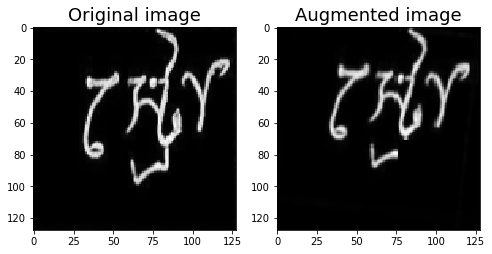

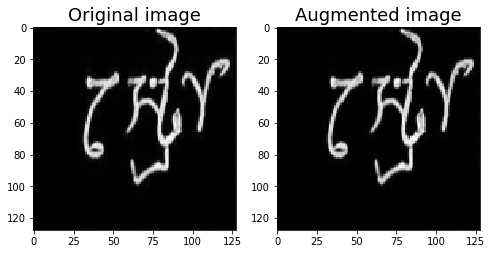

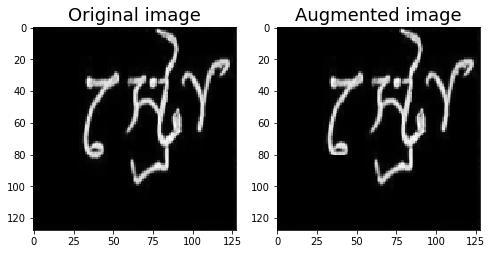

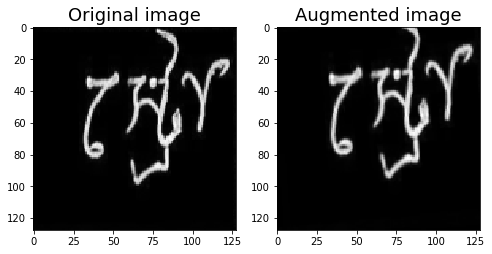

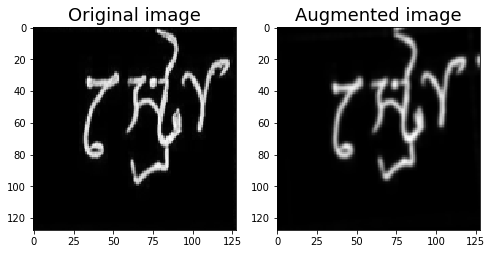

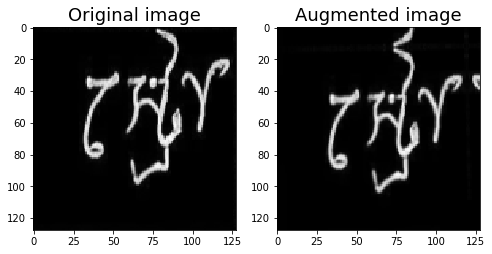

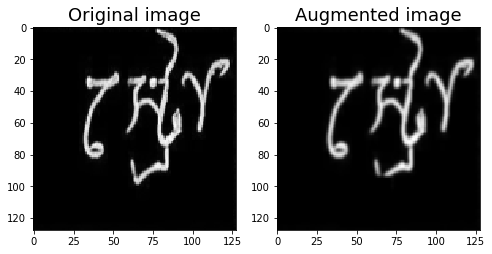

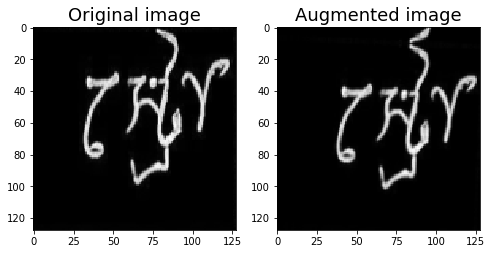

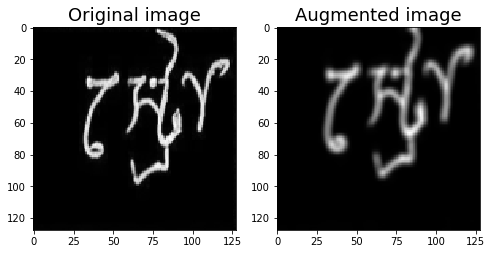

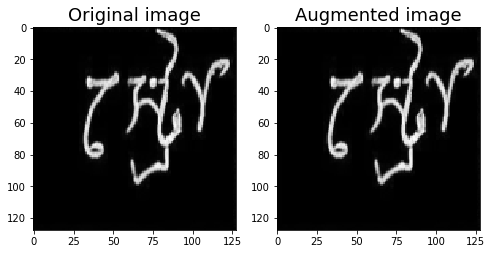

In [15]:
for i in range (10):
    aug_image = train_dataset[0][0]
    visualize (orig_image,aug_image)

In [16]:
del train_df,valid_df,data_train_df,data_valid_df 
torch.cuda.empty_cache()
gc.collect()

46677

In [0]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers = 16,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,num_workers = 16,shuffle=True)

In [0]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        #h = torch.cat([x, x, x], dim=1)
        #x = self.base_model.features(h)

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # vowel_diacritic
        self.fc1 = nn.Linear(512 * block.expansion,11)
        # grapheme_root
        self.fc2 = nn.Linear(512 * block.expansion,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(512 * block.expansion,7)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3
        #return torch.tensor( (x1,x2,x3), dtype=torch.float64)

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [0]:
class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        #h = torch.cat([x, x, x], dim=1) #hereeeeeeeeee
        #x = self.base_model.features(h)
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [0]:
def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#model = se_resnext50().to(device)
#model.load_state_dict(torch.load('/content/drive/My Drive/ors_bengal/cutmixup_seresnext.pth'))
epochs = 50
model = resnet34().to(device)


cuda:0


In [22]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
model.avg_pooling = GeM()
model.load_state_dict(torch.load('/content/drive/My Drive/black_128/bestresnet34.pth'))
#model.load_state_dict(torch.load('/content/drive/My Drive/ors_bengal/ors_b4.pth'))

<All keys matched successfully>

In [0]:
optimizer =torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, 2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                            mode="min", 
                                                            patience=5, 
                                                            factor=0.5,verbose=True)
criter = nn.CrossEntropyLoss()
batch_size=128

In [0]:
def ohem_loss( rate, cls_pred, cls_target ):

    batch_size = cls_pred.size(0) 
    ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, reduction='none', ignore_index=-1)

    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate) )
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets
# loss 
def cutmix_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    #criterion = ohem_loss
    lo1 = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2)
    lo2 = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
    lo3 = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
    return lo1,lo2,lo3


def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def mixup_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    #criterion = ohem_loss
    lo1 = lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2)
    lo2 = lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4)
    lo3 = lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)
    return  lo1,lo2,lo3 
    #return [ lam * criterion(rate, preds1, targets1) + (1 - lam) * criterion(rate, preds1, targets2), lam * criterion(rate, preds2, targets3) + (1 - lam) * criterion(rate, preds2, targets4), lam * criterion(rate, preds3, targets5) + (1 - lam) * criterion(rate, preds3, targets6) ]

In [0]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(y[:, 0], pred_labels[0],  average='macro')
    recall_vowel = sklearn.metrics.recall_score(y[:, 1], pred_labels[1],  average='macro')
    recall_consonant = sklearn.metrics.recall_score(y[:, 2], pred_labels[2],  average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score

def macro_recall_multi(pred_graphemes, true_graphemes,pred_vowels,true_vowels,pred_consonants,true_consonants, n_grapheme=168, n_vowel=11, n_consonant=7):
    #pred_y = torch.split(pred_y, [n_grapheme], dim=1)
    pred_label_graphemes = torch.argmax(pred_graphemes, dim=1).cpu().numpy()

    true_label_graphemes = true_graphemes.cpu().numpy()
    
    pred_label_vowels = torch.argmax(pred_vowels, dim=1).cpu().numpy()

    true_label_vowels = true_vowels.cpu().numpy()
    
    pred_label_consonants = torch.argmax(pred_consonants, dim=1).cpu().numpy()

    true_label_consonants = true_consonants.cpu().numpy()    
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(true_label_graphemes, pred_label_graphemes,  average='macro')
    recall_vowel = sklearn.metrics.recall_score(true_label_vowels, pred_label_vowels,  average='macro')
    recall_consonant = sklearn.metrics.recall_score(true_label_consonants, pred_label_consonants,  average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    #print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [0]:
import numpy
def train(epoch):
  model.train()
  losses = []
  accs = []
  acc= 0.0
  total = 0.0
  running_loss = 0.0
  running_acc = 0.0
  valid_recall = 0.0
  running_recall = 0.0
  for idx, (inputs,labels1,labels2,labels3) in enumerate(train_loader):
      inputs = inputs.unsqueeze(1).float()
      inputs = inputs.to(device)
      labels1 = labels1.to(device)
      labels2 = labels2.to(device)
      labels3 = labels3.to(device)
      total += len(inputs)
      optimizer.zero_grad()

      inputs, targets = cutmix(inputs, labels1, labels2, labels3, 0.5)
      outputs1,outputs2,outputs3 = model(inputs)
      loss1,loss2,loss3 = cutmix_criterion(outputs1,outputs2,outputs3, targets)  

      '''    
      if np.random.rand()<0.5:
          inputs, targets = mixup(inputs, labels1, labels2, labels3, 0.4)
          outputs1,outputs2,outputs3 = model(inputs)
          loss1,loss2,loss3 = mixup_criterion(outputs1,outputs2,outputs3, targets)
      else:
          inputs, targets = cutmix(inputs, labels1, labels2, labels3, 0.4)
          outputs1,outputs2,outputs3 = model(inputs)
          loss1,loss2,loss3 = cutmix_criterion(outputs1,outputs2,outputs3, targets)  
           '''
      running_recall+= macro_recall_multi(outputs2,labels2,outputs1,labels1,outputs3,labels3)
      running_loss += loss1.item()+loss2.item()+loss3.item()
      running_acc += (outputs1.argmax(1)==labels1).float().mean()
      running_acc += (outputs2.argmax(1)==labels2).float().mean()
      running_acc += (outputs3.argmax(1)==labels3).float().mean()
      (loss1+loss2+loss3).backward()
      optimizer.step()
      acc = running_acc/total
  
  losses.append(running_loss/len(train_loader))
  accs.append(running_acc/(len(train_loader)*3))
  print(' train epoch : {}\tacc : {:.2f}%'.format(epoch,running_acc/(len(train_loader)*3)))
  print('loss : {:.4f}'.format(running_loss/len(train_loader)))
  print('recall: {:.4f}'.format(running_recall/len(train_loader)))
  total_train_recall = running_recall/len(train_loader)
  torch.cuda.empty_cache()
  gc.collect()
  return total_train_recall
    
def evaluate(epoch):
   model.eval()
   losses = []
   accs = []
   recalls = []
   acc= 0.0
   total = 0.0
   #print('epochs {}/{} '.format(epoch+1,epochs))
   running_loss = 0.0
   running_acc = 0.0
   running_recall = 0.0
   with torch.no_grad():
     for idx, (inputs,labels1,labels2,labels3) in enumerate(valid_loader):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        total += len(inputs)
        outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
        loss1 = criter(outputs1,labels1)
        loss2 = 2*criter(outputs2,labels2)
        loss3 = criter(outputs3,labels3)
        running_loss += loss1.item()+loss2.item()+loss3.item()
        running_recall+= macro_recall_multi(outputs2,labels2,outputs1,labels1,outputs3,labels3)
        running_acc += (outputs1.argmax(1)==labels1).float().mean()
        running_acc += (outputs2.argmax(1)==labels2).float().mean()
        running_acc += (outputs3.argmax(1)==labels3).float().mean()
        acc = running_acc/total
   shed_rec = running_loss/len(valid_loader)
   scheduler.step(shed_rec)
   losses.append(running_loss/len(valid_loader))
   accs.append(running_acc/(len(valid_loader)*3))
   recalls.append(running_recall/len(valid_loader))
   total_recall = running_recall/len(valid_loader)
   print('val epoch: {} \tval acc : {:.2f}%'.format(epoch,running_acc/(len(valid_loader)*3)))
   print('loss : {:.4f}'.format(running_loss/len(valid_loader)))
   print('recall: {:.4f}'.format(running_recall/len(valid_loader)))
   return  total_recall

In [0]:
#hello
%%time
n_epochs = 200
best_valid_recall = 0.978 #0.982
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_recall = train(epoch)
    valid_recall = evaluate(epoch)
    if valid_recall > best_valid_recall:
        print(f'Validation recall has increased from:  {best_valid_recall:.4f} to: {valid_recall:.4f}. Saving checkpoint')
        torch.save(model.state_dict(), '/content/drive/My Drive/black_128/updatedbestresnet34Cutmixup.pth') ## Saving model weights based on best validation accuracy.
        best_valid_recall = valid_recall

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 train epoch : 0	acc : 0.62%
loss : 4.3470
recall: 0.5091
val epoch: 0 	val acc : 0.98%
loss : 1.1699
recall: 0.9670
 train epoch : 1	acc : 0.63%
loss : 3.8951
recall: 0.5294
val epoch: 1 	val acc : 0.98%
loss : 0.8841
recall: 0.9701
 train epoch : 2	acc : 0.65%
loss : 3.7424
recall: 0.5523
val epoch: 2 	val acc : 0.98%
loss : 1.1480
recall: 0.9594
 train epoch : 3	acc : 0.63%
loss : 3.8126
recall: 0.5297
val epoch: 3 	val acc : 0.98%
loss : 1.2807
recall: 0.9656
 train epoch : 4	acc : 0.65%
loss : 3.6683
recall: 0.5535
val epoch: 4 	val acc : 0.98%
loss : 0.8933
recall: 0.9710
 train epoch : 5	acc : 0.65%
loss : 3.5966
recall: 0.5511
val epoch: 5 	val acc : 0.98%
loss : 0.9004
recall: 0.9705
 train epoch : 6	acc : 0.67%
loss : 3.4708
recall: 0.5705
val epoch: 6 	val acc : 0.98%
loss : 1.1059
recall: 0.9716
 train epoch : 7	acc : 0.67%
loss : 3.4220
recall: 0.5735
Epoch     8: reducing learning rate of group 0 to 5.0000e-04.
val epoch: 7 	val acc : 0.99%
loss : 0.9629
recall: 0.9732
 t

In [0]:
# 9824
